# Prédiction des prix des biens immobiliers

## Analyse exploratoire des données

##### Libraries

In [1]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge  
from sklearn.linear_model import Lasso  
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
np.set_printoptions(precision=2, suppress=True)

/usr/lib/python3/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: cannot import name 'logsumexp'

### Téléchargement et préparation du jeu de données

In [2]:
data = pd.read_csv("real_estate.csv", index_col="Unnamed: 0")
data.head()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19,20,21,22,23,24,32,33,34,36,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


In [3]:
data.shape

(158957, 47)

### Tri des données

###### Étude du data dictionnary et visualisation de la data

D'après l'analyse du data dictionnary, on peut tirer les conclusions suivantes:

- **'NATIONALGRID'** représente l'adresse spatiale de la coordonnée de grille nationale d'emplacement d'adresse cette information est redondante car déjà donnée par le tuple (Latitude, Longitude et Zipcode ...).

- **'X','Y'** sont respectivement la longitude et la latitude, ces deux champs sont alors indiqués en double pour chaque observation.

- **'QUADRANT'**, **'FULLADDRESS'** et **'COMPLXNUM'** sont des informations déjà indiquées pas la longitude et la latitude car elles refèrent à la localisation du bien immobilier.

- **'ASSESSMENT_SUBNBHD'**, **'CENSUS_TRACT'**, **'CENSUS_BLOCK'**, **'BLDG_NUM'** et **'ASSESSMENY_NBHD'** sont des données à valeur unique.

- **'LIVING_GBA'** donne la même information que **'GBA'**. Cependant les champs **'GBA'** semblent avoir beaucoup moins de valeurs manquantes et peuvent être plus facilement compléter par la moyenne par exemple.

- **'CITY'** et **STATE'** sont les mêmes pour tous les biens. Les biens de l'étude se situent tous à Washington dans le District of Columbia, on peut supposer que ceci est le cas pour toutes les valeurs manquantes et donc les deux champs à valeur unique ne représentent pas d'interêt.

- **'SALENUM'** est le numéro de la vente il sert d'identifiant unique à chaque vente et n'apporte aucune information.

- **'GIS_LAST_MOD_DTTM'** cette donnée a une valeur unique.

Toutes ces variables, étant redondantes ou inutiles, peuvent être supprimer.

In [4]:
data=data.drop(['NATIONALGRID','ASSESSMENT_SUBNBHD','ASSESSMENT_NBHD','GIS_LAST_MOD_DTTM', 'CENSUS_BLOCK','X','Y','BLDG_NUM','CENSUS_TRACT','QUADRANT', 'CITY', 'STATE','SQUARE','SALE_NUM', 'LIVING_GBA','FULLADDRESS','CMPLX_NUM'], axis=1)

La variable **'PRICE'** est la variable cible 

In [92]:
print(data.PRICE.describe())

count    98216.000000
mean        49.414982
std         17.286910
min          1.000000
25%         41.120972
50%         47.931130
75%         55.497610
max        276.326246
Name: PRICE, dtype: float64


La variable **'PRICE'** contient aussi beaucoup de champs vide, il n'est pas possible d'entrainer un modèle en ignorant le prix.
Il est aussi impossible d'utiliser ces valeurs pour tester car on n'aura pas de base de comparaison, il est donc nécessaire de supprimer les lignes où le prix est nul.

In [6]:
data=data[data['PRICE'].notnull()]

### Étude des données

#### Données catégorielles

In [7]:
data.dtypes[data.dtypes=='object']

HEAT         object
AC           object
SALEDATE     object
QUALIFIED    object
STYLE        object
STRUCT       object
GRADE        object
CNDTN        object
EXTWALL      object
ROOF         object
INTWALL      object
SOURCE       object
WARD         object
dtype: object

Les données sont constituées de 13 données catégorielles.

In [8]:
data.describe(include=['object'])

,HEAT,AC,SALEDATE,QUALIFIED,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,SOURCE,WARD
count,98216,98216,98215,98216,57900,57900,57900,57900,57900,57900,57900,98216,98216
unique,14,3,6529,2,18,8,13,7,24,16,12,2,8
top,Forced Air,Y,2007-04-10 00:00:00,Q,2 Story,Row Inside,Average,Good,Common Brick,Built Up,Hardwood,Residential,Ward 6
freq,39423,79683,258,76233,44150,23425,19664,25711,43369,17633,44180,57900,16263


Le variable **'AC'** est une variable binaire indiquant si un bien est climatisé ou pas.
Cependant on remarque que l'enregistrement d'absence de climatisation dans un bien est exprimé dans certains cas par un N et dans d'autres par un 0.

In [9]:
print(data.AC.describe())
list(set(data.AC))

count     98216
unique        3
top           Y
freq      79683
Name: AC, dtype: object


['N', '0', 'Y']

In [10]:
data.AC.replace('0', 'N', inplace = True)

Text(0.5, 1.0, 'Variable AC')

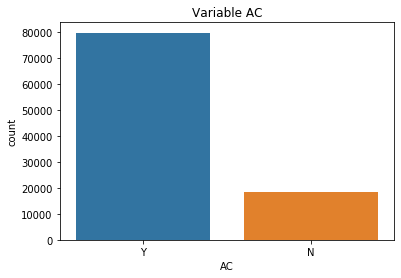

In [11]:
sns.countplot('AC', data=data).set_title('Variable AC')

Les autres variables binaires.

Text(0.5, 1.0, 'Variable Qualified')

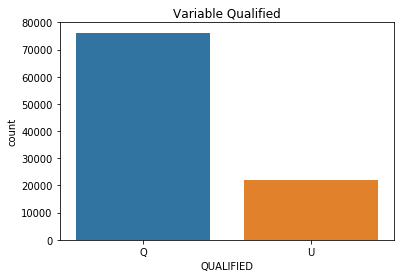

In [12]:
sns.countplot('QUALIFIED', data=data).set_title('Variable Qualified')

Text(0.5, 1.0, 'Variable Source')

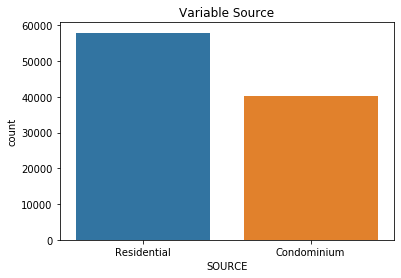

In [13]:
sns.countplot('SOURCE', data=data).set_title('Variable Source')

La majorité des biens semble être climatisée et qualifiée.
Et les observations sont fournis majoritairement par la source 'Résidential'.

Text(0.5, 1.0, 'Variable Heat')

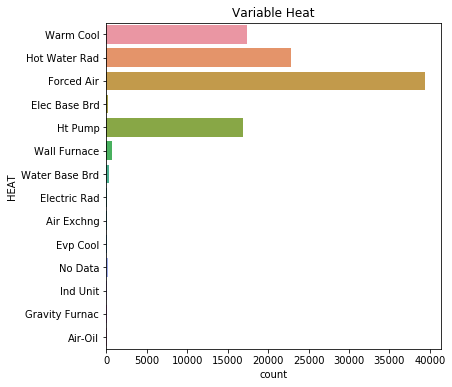

In [14]:
plt.figure(figsize=(6,6))
sns.countplot(y='HEAT', data=data).set_title('Variable Heat')

On remarque que la variable **'HEAT'** indiquant le type de chauffage dans les biens est constituée de 4 classes dominantes, les autres types sont assez dispersés (sparse).
Ces valeurs peuvent être cause de surapprentissage par la suite.

In [15]:
autres = ['Air-Oil','Gravity Furnac', 'No Data', 'Evp Cool', 'Air Exchng', 'Water Base Brd', 'Ind Unit', 'Wall Furnace', 'Electric Rad','Elec Base Brd']
data.HEAT.replace(autres, 'Other', inplace=True)

Text(0.5, 1.0, 'Variable Heat')

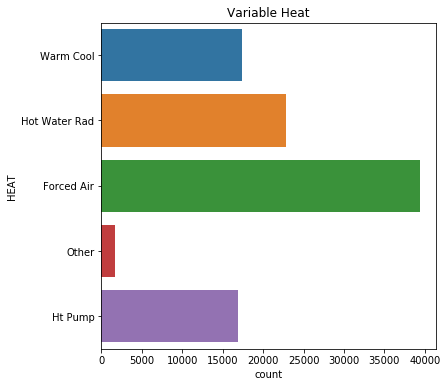

In [16]:
plt.figure(figsize=(6,6))
sns.countplot(y='HEAT', data=data).set_title('Variable Heat')

Text(0.5, 1.0, 'Variable ROOF')

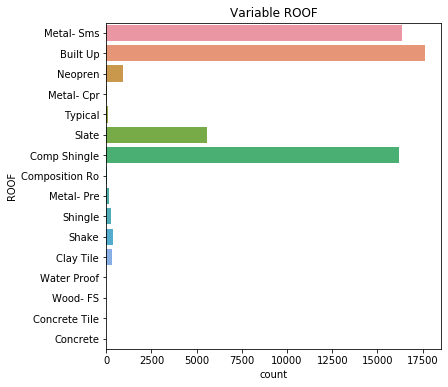

In [17]:
plt.figure(figsize=(6,6))
sns.countplot(y='ROOF', data=data).set_title('Variable ROOF')

De la même façon le toit semble être assez souvent composé de 4 catégories précises, les restantes sont très rarement utilisées.

In [18]:
autres = ['Neopren', 'Metal- Cpr', 'Typical', 'Composition Ro', 'Metal- Pre', 'Shingle', 'Shake', 'Clay Tile', 'Water Proof', 'Wood- FS', 'Concrete Tile', 'Concrete']
data.ROOF.replace(autres, 'Other', inplace=True)

Text(0.5, 1.0, 'Variable Roof')

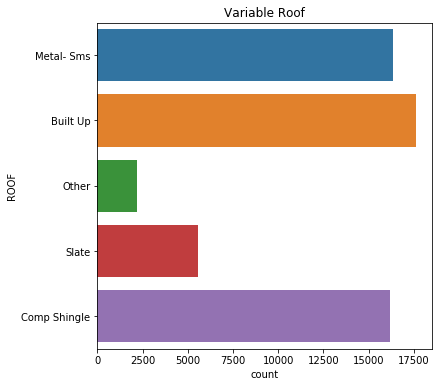

In [19]:
plt.figure(figsize=(6,6))
sns.countplot(y='ROOF', data=data).set_title('Variable Roof')

Text(0.5, 1.0, 'Variable Intwall')

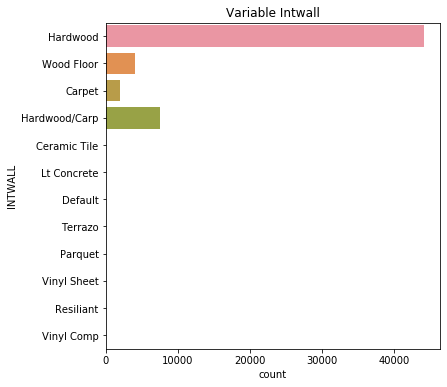

In [20]:
plt.figure(figsize=(6,6))
sns.countplot(y='INTWALL', data=data).set_title('Variable Intwall')

L'intérieur des biens est principalement recouvert en bois de plusieurs types (vinyl, parquet, bois dure ...).
Nous allons regrouper ces recouvrement en deux catégories.

In [21]:
bois = ['Hardwood', 'Wood Floor', 'Parquet','Vinyl Sheet', 'Vinyl Comp']
data.INTWALL.replace(bois, 'Wood', inplace=True)
autres = ['Carpet', 'Hardwood/Carp', 'Lt Concrete', 'Default', 'Terrazo', 'Resiliant', 'Ceramic Tile']
data.INTWALL.replace(autres, 'Others', inplace=True)

Text(0.5, 1.0, 'Variable Intwall')

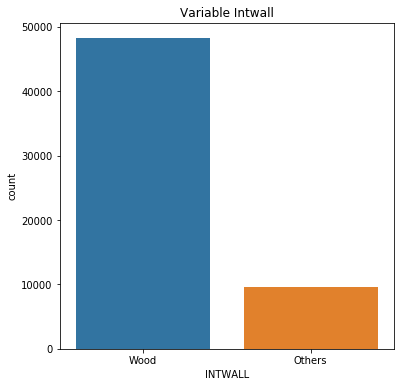

In [22]:
plt.figure(figsize=(6,6))
sns.countplot('INTWALL', data=data).set_title('Variable Intwall')

Text(0.5, 1.0, 'Variable Extwall')

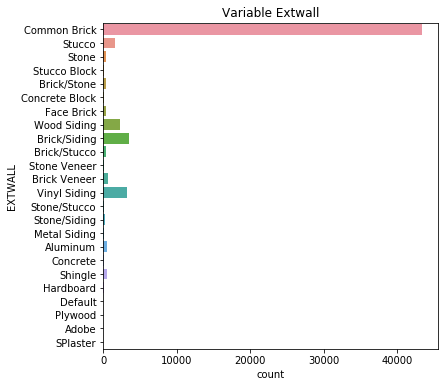

In [23]:
plt.figure(figsize=(6,6))
sns.countplot(y='EXTWALL', data=data).set_title('Variable Extwall')

Le recouvement des façades se fait généralement par des briques ou des pierres.
Nous allons regrouper ces recouvrement en deux catégories.

In [24]:
pierre = ['Common Brick', 'Stone', 'Brick/Stone', 'Concrete Block', 'Face Brick', 'Brick/Siding', 'Brick/Stucco', 'Stone Veneer', 'Brick Veneer', 'Stone/Stucco', 'Stone/Siding', 'Plywood']
data.EXTWALL.replace(pierre, 'Stone', inplace=True)
autres = ['Stucco', 'Wood Siding', 'Vinyl Siding', 'Metal Siding', 'Aluminum', 'Concrete', 'Shingle', 'Hardboard', 'Default', 'SPlaster', 'Adobe' , 'Stucco Block']
data.EXTWALL.replace(autres, 'Others', inplace=True)

Text(0.5, 1.0, 'Variable Extwall')

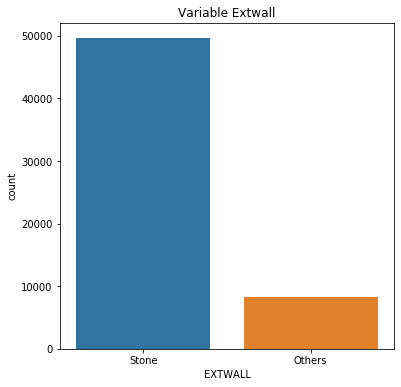

In [25]:
plt.figure(figsize=(6,6))
sns.countplot('EXTWALL', data=data).set_title('Variable Extwall')

Text(0.5, 1.0, 'Struct')

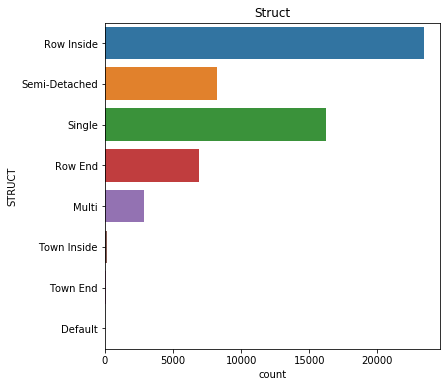

In [26]:
plt.figure(figsize=(6,6))
sns.countplot(y='STRUCT', data=data).set_title('Struct')

In [27]:
autres = ['Multi','Town Inside', 'Town End', 'Default']
data.STRUCT.replace(autres, 'Other', inplace=True)

Text(0.5, 1.0, 'Struct')

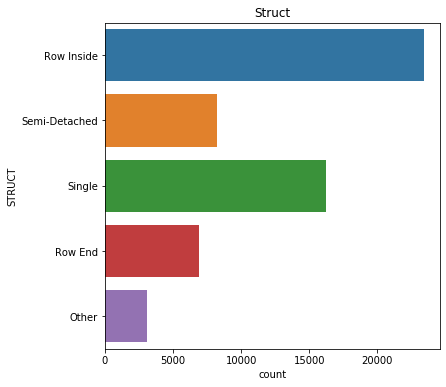

In [28]:
plt.figure(figsize=(6,6))
sns.countplot(y='STRUCT', data=data).set_title('Struct')

Text(0.5, 1.0, 'CNDTN')

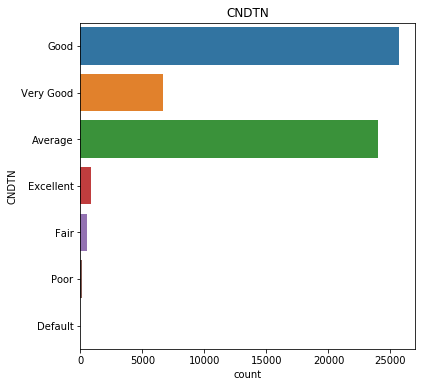

In [29]:
plt.figure(figsize=(6,6))
sns.countplot(y='CNDTN', data=data).set_title('CNDTN')

'Fair' désigne quelque chose dans la moyenne et on peut considérer que les biens qualifiés par 'Default' ont une qualité moyenne, on peut regrouper ces deux catégories dans la catégorie 'Average'.

In [30]:
autres = ['Fair','Default']
data.CNDTN.replace(autres, 'Average', inplace=True)

Text(0.5, 1.0, 'CNDTN')

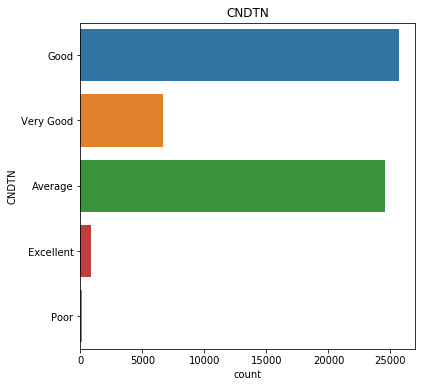

In [31]:
plt.figure(figsize=(6,6))
sns.countplot(y='CNDTN', data=data).set_title('CNDTN')

Text(0.5, 1.0, 'Ward')

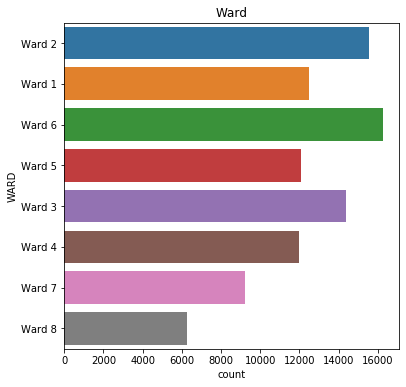

In [32]:
plt.figure(figsize=(6,6))
sns.countplot(y='WARD', data=data).set_title('Ward')

Tous les quartiers sont proportionellement représentés

Text(0.5, 1.0, 'Grade')

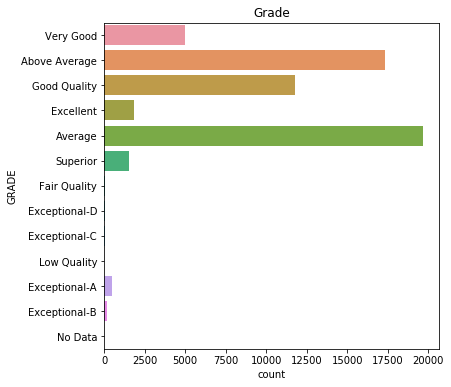

In [33]:
plt.figure(figsize=(6,6))
sns.countplot(y='GRADE', data=data).set_title('Grade')

Exceptional-A/B/C/D et Superior sont des biens Excellent.
Fair Quality  et Average désignent des biens du même type.

In [34]:
autres = ['Exceptional-A','Exceptional-B','Exceptional-C','Exceptional-D', 'Superior']
data.GRADE.replace(autres, 'Excellent', inplace=True)
data.GRADE.replace('Fair Quality', 'Average', inplace=True)

Text(0.5, 1.0, 'Grade')

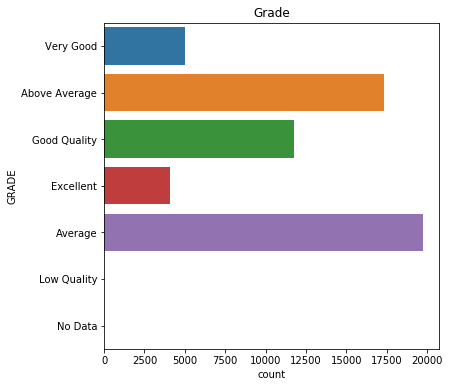

In [35]:
plt.figure(figsize=(6,6))
sns.countplot(y='GRADE', data=data).set_title('Grade')

Text(0.5, 1.0, 'Style')

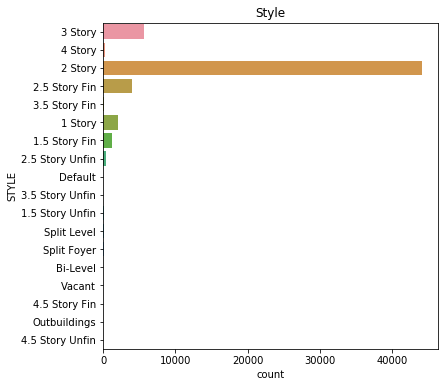

In [36]:
plt.figure(figsize=(6,6))
sns.countplot(y='STYLE', data=data).set_title('Style')

Les biens les plus présents sur le marché sont les biens à 2 pièces.

In [37]:
autres = ['4.5 Story Unfin', '1.5 Story Unfin', 'Outbuildings', '4.5 Story Fin', 'Vacant', 'Bi-Level', 'Split Foyer','Split Level', '3.5 Story Unfin', 'Default', '2.5 Story Unfin', '1.5 Story Fin', '3.5 Story Fin', '2.5 Story Fin', '1 Story','4 Story','3 Story' ]
data.STYLE.replace(autres, 'Others', inplace=True)

Text(0.5, 1.0, 'Style')

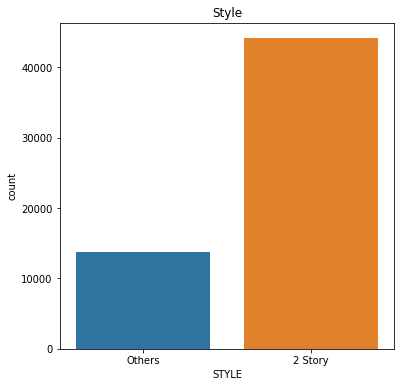

In [38]:
plt.figure(figsize=(6,6))
sns.countplot('STYLE', data=data).set_title('Style')

La variable **'SALEDATE'** indique l'année de vente du bien.
Selon les années de vente le secteur immobilier subit beaucoup de transitions, certaines années semblent avoir une demande élevée ce qui conduit les prix à la hausse.
À partir de la variable **'SALEDATE'** nous allons extraire l'année de vente pour étudier les tendances et voir leur impact.

In [39]:
data['SALEDATE']=data['SALEDATE'].str[0:4]

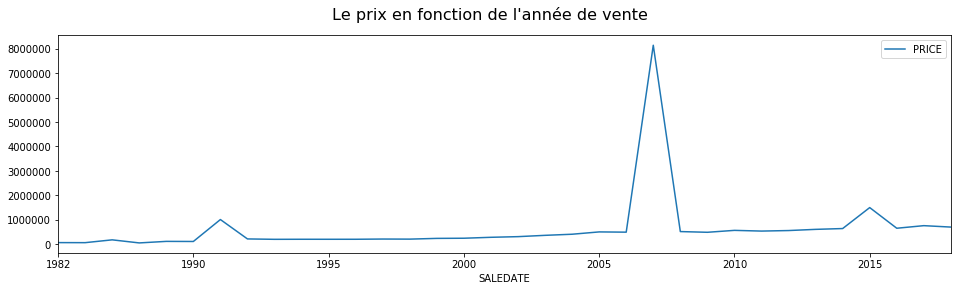

In [40]:
t_sales = data[data.PRICE > 0]
fig, ax = plt.subplots()
t_sales.groupby("SALEDATE").mean().reset_index().plot(x="SALEDATE",y="PRICE",ax=ax)
fig.set_size_inches(16,4)
fig.suptitle('Le prix en fonction de l\'année de vente', fontsize=16)
plt.show()

On remarque que effectivement entre 2005 et 2010 les prix des biens ont connu une hausse.
Ce qui correspond à la bulle immobilière américaine des années 2000. Un pic de l'indice des prix immobiliers a été observé début 2005. Le déclin brutal commencé début 2006 par la crise des subprimes se poursuit toujours à l'heure actuelle avec une baisse observée le 27 décembre 2011 par l'indice Case-Shiller des prix immobiliers.

Observons maintenant si les variables catégorielles représentent des valeurs manquantes

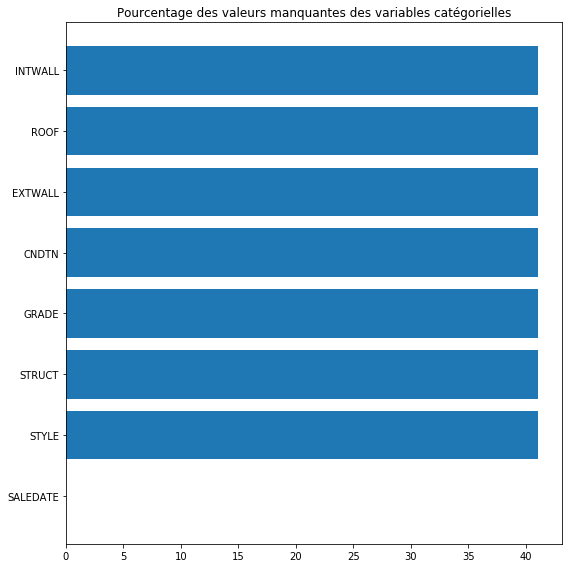

In [41]:
data_null = (data.select_dtypes(include=['object']).isnull().sum() / len(data)) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=True)
figure = plt.figure(figsize = (8, 8))
plt.barh(data_null.index,data_null,linewidth = 3)
plt.title('Pourcentage des valeurs manquantes des variables catégorielles')
plt.tight_layout()
plt.show()

Il manque environ 41 % des valeurs pour plusieurs variables.
Afin de compléter au mieux ces variables on utilise la fonction fillna.

In [42]:
data['CNDTN'].fillna(data['CNDTN'].mode().iloc[0], inplace=True)
data['EXTWALL'].fillna(data['EXTWALL'].mode().iloc[0], inplace=True)
data['ROOF'].fillna(data['ROOF'].mode().iloc[0], inplace=True)
data['INTWALL'].fillna(data['INTWALL'].mode().iloc[0], inplace=True)
data['STYLE'].fillna(data['STYLE'].mode().iloc[0], inplace=True)
data['GRADE'].fillna(data['GRADE'].mode().iloc[0], inplace=True)
data['STRUCT'].fillna(data['STRUCT'].mode().iloc[0], inplace=True)
data['SALEDATE'].fillna(data['SALEDATE'].mode().iloc[0], inplace=True)

#### Données numériques

#### Étude des données numériques

In [43]:
data.dtypes[data.dtypes!='object']

BATHRM          int64
HF_BATHRM       int64
NUM_UNITS     float64
ROOMS           int64
BEDRM           int64
AYB           float64
YR_RMDL       float64
EYB             int64
STORIES       float64
PRICE         float64
GBA           float64
KITCHENS      float64
FIREPLACES      int64
USECODE         int64
LANDAREA        int64
ZIPCODE       float64
LATITUDE      float64
LONGITUDE     float64
dtype: object

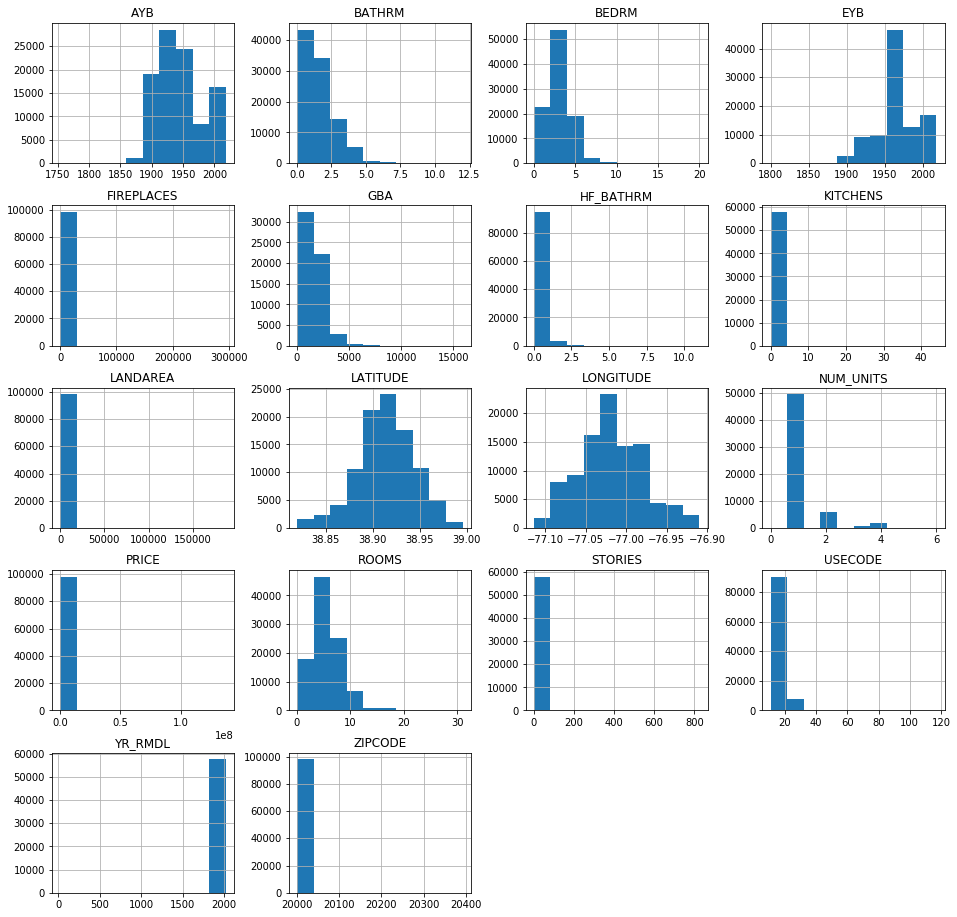

In [44]:
data.hist(figsize=(16,16))
plt.show()

- On remarque que des biens immobiliers ont été construits après 1850 et jusqu'à 2018, ces biens ont des propriétés différentes comme le nombre de chambres, de cuisines et de salles de bain.
- Les biens sont de superficies différentes et les ventes sont enregistrées peu de temps après l'année de construction et continuent toujours.
- Cependant plus de 50000 biens possèdent une seule pièce et au moins une salle de bain.

- 60000 biens ont été modifiés après leurs constructions

In [45]:
data.describe()

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,PRICE,GBA,KITCHENS,FIREPLACES,USECODE,LANDAREA,ZIPCODE,LATITUDE,LONGITUDE
count,98216.000000,98216.000000,57900.000000,98216.000000,98216.000000,98104.000000,57674.000000,98216.000000,57867.000000,9.821600e+04,57900.000000,57899.000000,98216.000000,98216.000000,98216.000000,98216.000000,98216.000000,98216.000000
mean,1.859157,0.444541,1.221071,5.921836,2.606480,1944.903888,2000.666748,1965.759876,2.124667,9.313516e+05,1725.786304,1.250902,3.521972,14.613393,2084.296123,20012.303525,38.913911,-77.018076
std,0.978321,0.576217,0.623997,2.637816,1.393801,36.254098,16.136807,27.500116,3.948764,7.061325e+06,825.850328,0.661330,937.972785,3.683449,2765.429658,16.326982,0.030185,0.039794
min,0.000000,0.000000,0.000000,0.000000,0.000000,1754.000000,20.000000,1800.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,11.000000,0.000000,20001.000000,38.819731,-77.113909
25%,1.000000,0.000000,1.000000,4.000000,2.000000,1917.000000,1991.000000,1954.000000,2.000000,2.400000e+05,1216.000000,1.000000,0.000000,11.000000,482.000000,20005.000000,38.895973,-77.042758
50%,2.000000,0.000000,1.000000,6.000000,3.000000,1939.000000,2005.000000,1965.000000,2.000000,3.999990e+05,1504.000000,1.000000,0.000000,13.000000,1380.000000,20010.000000,38.914207,-77.021489
75%,2.000000,1.000000,1.000000,7.000000,3.000000,1966.000000,2011.000000,1981.000000,2.000000,6.520000e+05,1984.000000,1.000000,1.000000,17.000000,2556.000000,20017.000000,38.933797,-76.990601
max,12.000000,11.000000,6.000000,31.000000,20.000000,2018.000000,2019.000000,2018.000000,826.000000,1.374275e+08,15902.000000,44.000000,293920.000000,117.000000,187301.000000,20392.000000,38.995435,-76.909758


La variable **'YR_RMLD'** est une variable indiquant la date de la rénovation de la structure, on remaque que l'on dispose aussi d'une variable **'EYB'** qui elle ne contient aucune valeur manquant et indique l'année où une amélioration a été réalisé après la construction.
On peut faire coïncider les deux variables en supposant que si aucune date de rénovation n'est indiquée alors aucune rénovation n'a été faite dans la structure depuis la dernière amélioration.
On remplace donc la valeur manquante de la variable **'YR_RMLD'** par celle de la variable **'EYB'**.

In [46]:
data.loc[data['YR_RMDL'].isnull(), 'YR_RMDL'] = data['EYB']

La variable **'AYB'** qui indique la date la plus antérieure de la contruction de la structure.

In [47]:
print(data.AYB.describe())

count    98104.000000
mean      1944.903888
std         36.254098
min       1754.000000
25%       1917.000000
50%       1939.000000
75%       1966.000000
max       2018.000000
Name: AYB, dtype: float64


Majoritairement les biens ont été construits après 1944, afin de préserver la nature de la data et la moyenne de la variable nous allons remplacer les champs manquants par la date moyenne.


In [48]:
data['AYB'].fillna((data['AYB'].mean()), inplace=True)

De la même façon, nous pouvons remplacer les valeurs manquantes de la variable **'GBA'** représentant la surface brute du bâtiment par la moyenne.

In [49]:
data['GBA'].fillna((data['GBA'].mean()), inplace=True)

**'STORIES'** indique le nombre d'étage par bien, nous pouvons remplacer les valeurs manquantes de cette variable par la moyenne des étages en se basant sur le fait que dans une zone d'habitation les biens ont majoriterement le même nombre d'étage comme l'indique la description de la variable ci-dessous.

In [50]:
print(data.STORIES.describe())
data['STORIES'].fillna((data['STORIES'].mean()), inplace=True)

count    57867.000000
mean         2.124667
std          3.948764
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        826.000000
Name: STORIES, dtype: float64


In [51]:
print(data.LATITUDE.describe())
print(data.LONGITUDE.describe())

count    98216.000000
mean        38.913911
std          0.030185
min         38.819731
25%         38.895973
50%         38.914207
75%         38.933797
max         38.995435
Name: LATITUDE, dtype: float64
count    98216.000000
mean       -77.018076
std          0.039794
min        -77.113909
25%        -77.042758
50%        -77.021489
75%        -76.990601
max        -76.909758
Name: LONGITUDE, dtype: float64


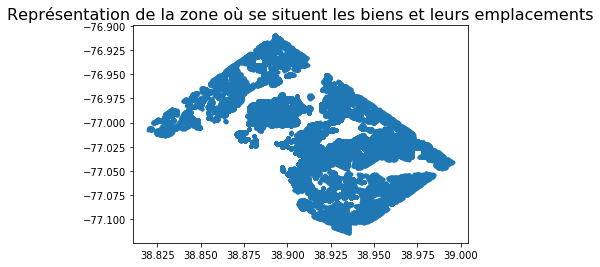

In [52]:
plt.plot(data['LATITUDE'], data['LONGITUDE'], ".")
plt.title('Représentation de la zone où se situent les biens et leurs emplacements', fontsize=16)
plt.show()

**'LATITUDE'** et **'LONGITUDE'** indiquent le couple de coordonnées géographiques. Ils recouvrent une zone précise comprise entre 38.913911 et 38.995435 en latitude et -77.113909 et -76.909758 en longitude.
On suppose que les valeurs manquantes sont au milieu de la zone précisée au dessus pour remplacer les valeur manquantes.

In [53]:
data['LATITUDE'].fillna((max(data.LATITUDE)+min(data.LATITUDE))/2, inplace=True)
data['LONGITUDE'].fillna((max(data.LONGITUDE)+min(data.LONGITUDE))/2, inplace=True)   

Pour les variables restantes les champs sans valeurs sont plus difficile à remplir, car les tendances et les valeurs usuelles sont compliquées à prédire notamment pour les variables catégorielles comme **'ROOF'** qui donne la matière de recouvrement des toits par exemple, pour remplacer ces valeurs nous allons procéder par remplissage selon la valeur la plus fréquente pour chacune des variables grâce à la fonction *mode()* du package ***Panda***.

In [54]:
data['KITCHENS'].fillna(data['KITCHENS'].mode().iloc[0], inplace=True)
data['CNDTN'].fillna(data['CNDTN'].mode().iloc[0], inplace=True)
data['EXTWALL'].fillna(data['EXTWALL'].mode().iloc[0], inplace=True)
data['ROOF'].fillna(data['ROOF'].mode().iloc[0], inplace=True)
data['INTWALL'].fillna(data['INTWALL'].mode().iloc[0], inplace=True)
data['STYLE'].fillna(data['STYLE'].mode().iloc[0], inplace=True)
data['ZIPCODE'].fillna(data['ZIPCODE'].mode().iloc[0], inplace=True)
data['NUM_UNITS'].fillna(data['NUM_UNITS'].mode().iloc[0], inplace=True)

#### Étude de la variable cible

La variable **'PRICE'** est la variable cible 

In [55]:
print(data.PRICE.describe())

count    9.821600e+04
mean     9.313516e+05
std      7.061325e+06
min      1.000000e+00
25%      2.400000e+05
50%      3.999990e+05
75%      6.520000e+05
max      1.374275e+08
Name: PRICE, dtype: float64


Text(0.5, 1.0, 'Distribution des prix')

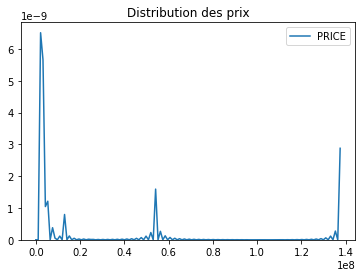

In [56]:
sns.kdeplot(data['PRICE']).set_title("Distribution des prix")

Le prix des biens varient entre 1 et $1.3*10^8$, les prix se situent en moyenne à $9,31*10^5$ et sont étendu sur une grande fourchette.
Afin de réduire cette écart, il faut transformer la data en utilisant la fonction log ou racine cubique afin de normaliser la distribution.
Àprès avoir tester les deux possibilités, il s'avère plus pertinent d'utiliser la fonction racine cubique car la fonction log réduit énormement les prix.

Text(0.5, 1.0, 'Nouvelle distribution')

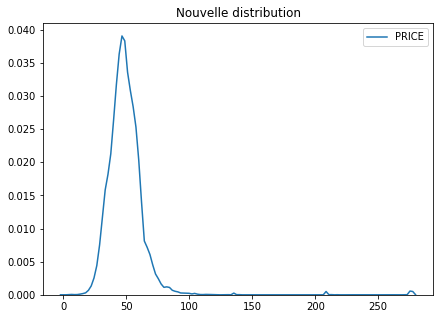

In [57]:
data.PRICE=(data.PRICE)**0.3
figure = plt.figure(figsize = (7, 5))
sns.kdeplot(data['PRICE']).set_title("Nouvelle distribution")

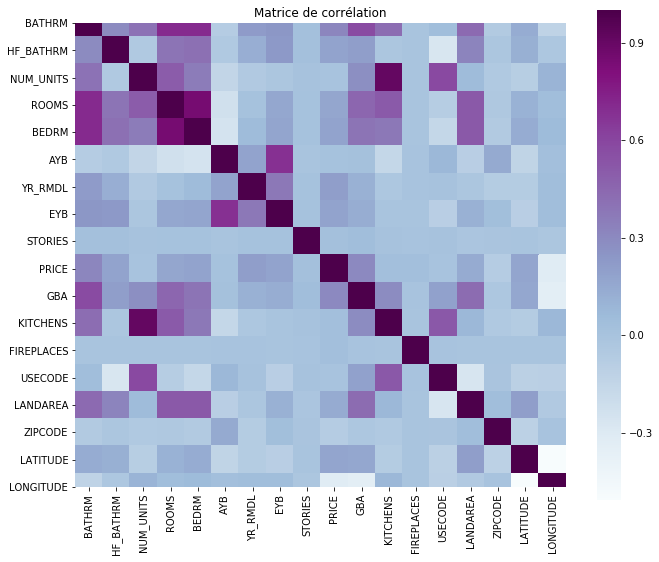

In [58]:
corr = data.corr()
plt.figure(figsize=(11,9))
sns.heatmap(corr, square = True,annot=False, cmap= 'BuPu').set_title('Matrice de corrélation')
plt.show()

Les données ne semblent pas corrélées à la variable cible.

#### Création des dummys variables

In [59]:
data = pd.get_dummies(data, prefix='HEAT', columns=['HEAT'])
data = pd.get_dummies(data, prefix='AC', columns=['AC'])
data = pd.get_dummies(data, prefix='QUALIFIED', columns=['QUALIFIED'])
data = pd.get_dummies(data, prefix='STYLE', columns=['STYLE'])
data = pd.get_dummies(data, prefix='STRUCT', columns=['STRUCT'])
data = pd.get_dummies(data, prefix='GRADE', columns=['GRADE'])
data = pd.get_dummies(data, prefix='CNDTN', columns=['CNDTN'])
data = pd.get_dummies(data, prefix='EXTWALL', columns=['EXTWALL'])
data = pd.get_dummies(data, prefix='ROOF', columns=['ROOF'])
data = pd.get_dummies(data, prefix='INTWALL', columns=['INTWALL'])
data = pd.get_dummies(data, prefix='SOURCE', columns=['SOURCE'])
data = pd.get_dummies(data, prefix='WARD', columns=['WARD'])

In [60]:
data['SALEDATE']=data['SALEDATE'].astype(str).astype('int64')

## Enregistrement du nouveau jeu de données

In [61]:
data.to_csv('new_real_estate.csv', index=None)

## Prédiction

##### Libraries

Le but de cette étude est de construire un modèle prédictif qui nous permet de déterminer les variables les plus influentes afin de prédire le prix des biens immobiliers.

Nous disposons d'un jeu de données initiale que nous avons traité dans la première partie, après avoir effectuer plusieurs changements, nous avons enregistré un nouveau jeu de données résumant les résultats de cette partie.

Dans la seconde partie nous utiliserons le nouveau jeu de données.

In [62]:
data.shape

(98216, 66)

### Choix des indicateurs d'écart
Afin de comparer et de tester la pertinance des modèles utilisés dans la suite, on utilisera:
- Mean squared error et r squared afin de tester la pertinance et l'optimalité d'un modèle (MSE, $R^2$).
- Root Mean Squared Percentage Error afin de comparer les modèles et choisir le meilleur (RMSPE) calculé grâce à la formule:

$$\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\frac{y_i - \hat{y_i}}{y_i}\right)^2}$$

In [63]:
def Root_Mean_Squared_Percentage_Error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))

### Création du train set et test set
Afin de constituer le train set et le test set, nous partageons la data en deux parties, une ne contenant que les lignes dont l'index n'est pas multiple de 5, qui constituera le train set.
Les lignes omisent serveront alors pour constituer le test set.

In [64]:
train = data[data.index %5 != 0]
test = data[data.index %5 == 0]
train.reset_index(drop=True)
test.reset_index(drop=True)
print(train.shape, test.shape)

(78421, 66) (19795, 66)


Nous obtenons ainsi un train set avec ***80%*** des observations et un test set avec ***20%*** des observations.

In [65]:
x_train=train.drop(['PRICE'], axis=1)
y_train= train['PRICE']

x_test=test.drop(['PRICE'], axis=1)
y_test= test['PRICE']

### Modèle 1 - OLS 

In [66]:
#Apprentissage et prédition
OLS = sm.OLS(y_train,x_train).fit()
OLS.params
print(OLS.summary())
y_pred_OLS = OLS.predict(x_test)

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     719.5
Date:                Wed, 24 Jul 2019   Prob (F-statistic):               0.00
Time:                        02:58:23   Log-Likelihood:            -3.1944e+05
No. Observations:               78421   AIC:                         6.390e+05
Df Residuals:                   78367   BIC:                         6.395e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
BATHRM                   1.9321 

In [67]:
#Calcul d'erreurs
print("RMPSE modèle OLS",Root_Mean_Squared_Percentage_Error(y_test,y_pred_OLS)*100 , '%')
print("MSE modèle OLS",mean_squared_error(y_test,y_pred_OLS))
print("R2 modèle OLS",r2_score(y_test,y_pred_OLS))

RMPSE modèle OLS 19.86787586993404 %
MSE modèle OLS 195.02057576409567
R2 modèle OLS 0.33243883745994496


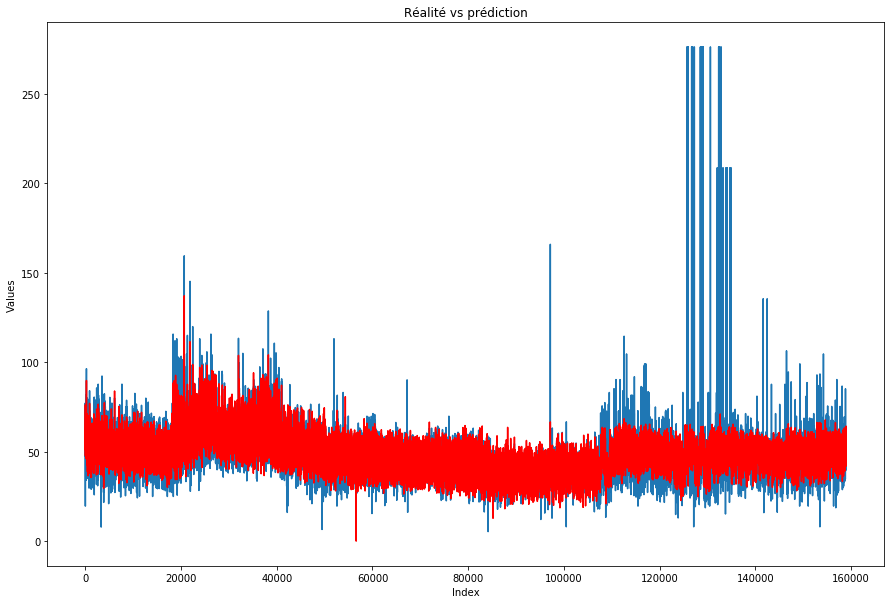

In [68]:
figure = plt.figure(figsize = (15, 10))
plt.plot(y_test,label="valeurs réelles")
plt.plot(y_pred_OLS, color='red', label="valeurs prédites")
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Réalité vs prédiction')
plt.show()

Le premier modèle offre un résultat avec environ 20% d'erreur quadratique moyenne.
Cependant MSE est encore très élevé par rapport à la distribution des données et $R^2$ est faible.
Le modèle doit être amélioré.

On remarque par ailleurs que selon les coefficients de la régression certaines variables sont peu significatives pour le modèle. Le nombre de variable utilisé est très important pour les prochains modèles il faudra prévoir une selection de variables afin de faire disparaitre les variables inutiles ou corrélées.

In [69]:
#selection de variables (Stepwise) inspiré par le code Dale David sur StackExchange,
#lien: https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn

def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, ):
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
        if not changed:
            break
    return included

selection = stepwise_selection(x_train, y_train)

/home/hassini/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [70]:
print(selection)
x_train = x_train[selection]
x_test = x_test[selection]

['AC_N', 'GRADE_Average', 'GBA', 'BATHRM', 'LONGITUDE', 'AC_Y', 'SALEDATE', 'WARD_Ward 8', 'EYB', 'AYB', 'HEAT_Ht Pump', 'HF_BATHRM', 'WARD_Ward 4', 'WARD_Ward 5', 'WARD_Ward 1', 'NUM_UNITS', 'QUALIFIED_U', 'QUALIFIED_Q', 'WARD_Ward 7', 'BEDRM', 'GRADE_Excellent', 'YR_RMDL', 'FIREPLACES', 'GRADE_No Data', 'LANDAREA', 'CNDTN_Very Good', 'ZIPCODE', 'WARD_Ward 6', 'INTWALL_Others', 'INTWALL_Wood', 'STRUCT_Other', 'HEAT_Other', 'ROOMS', 'CNDTN_Average', 'HEAT_Warm Cool', 'SOURCE_Residential', 'SOURCE_Condominium', 'EXTWALL_Others', 'EXTWALL_Stone', 'CNDTN_Excellent', 'GRADE_Above Average', 'ROOF_Comp Shingle', 'STYLE_2 Story', 'STYLE_Others']


### Modèle 2 - Ridge

In [71]:
#tuning choix des meilleurs paramètres
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge = GridSearchCV(Ridge(), tuned_params, cv=10, n_jobs=-1)
ridge.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [72]:
#meilleur parametrage
ridge.best_estimator_


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

On trouve $\alpha = 1$

In [73]:
#prédiction
y_pred_ridge = ridge.predict(x_test)

In [74]:
#calcul d'erreur
print("RMSPE modèle Ridge",Root_Mean_Squared_Percentage_Error(y_test,y_pred_ridge)*100 , '%')
print("MSE modèle Ridge",mean_squared_error(y_test,y_pred_ridge))
print("R2 modèle Ridge",r2_score(y_test,y_pred_ridge))

RMSPE modèle Ridge 19.834340281808274 %
MSE modèle Ridge 195.0559046408355
R2 modèle Ridge 0.3323179056765406


### Modèle 3 - Lasso

In [75]:
#tuning
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso = GridSearchCV(Lasso(), tuned_params, cv=20, n_jobs=-1)
lasso.fit(x_train, y_train)

GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [76]:
#meilleur parametrage
lasso.best_estimator_

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

On trouve $\alpha = 0.0001 $

In [77]:
#prédiction
y_pred_lasso = lasso.predict(x_test)

In [78]:
#calcul d'erreur
print("RMSPE modèle Lasso",Root_Mean_Squared_Percentage_Error(y_test,y_pred_lasso)*100 , '%')
print("MSE modèle Lasso",mean_squared_error(y_test,y_pred_lasso))
print("R2 modèle Lasso",r2_score(y_test,y_pred_lasso))

RMSPE modèle Lasso 19.779889083892918 %
MSE modèle Lasso 195.08308409199066
R2 modèle Lasso 0.33222486961642617


### Modèle 4 - KN Regresssion

In [79]:
params = list(range(1,10,2))
scores = []

for k in params:
    KNR = KNeighborsRegressor(n_neighbors=k)
    score = cross_val_score(KNR, x_train, y_train, cv=10)
    scores.append(score.mean())

k = params[scores.index(max(scores))]


In [80]:
print('nombre de voisin optimal est ',k)

nombre de voisin optimal est  3


In [81]:
KNR = KNeighborsRegressor(3)
KNR.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [82]:
y_pred_KNR = KNR.predict(x_test)

In [83]:
print("RMSPE modèle KNR",Root_Mean_Squared_Percentage_Error(y_test,y_pred_KNR)*100 , '%')
print("MSE modèle KNR",mean_squared_error(y_test,y_pred_KNR))
print("R2 modèle KNR",r2_score(y_test,y_pred_KNR))

RMSPE modèle KNR 24.135723887499925 %
MSE modèle KNR 87.47139188003527
R2 modèle KNR 0.7005828547903228


### Modèle 4 - Random Forest

J'ai mis la partie tuning ici en commentaire car elle prenait énormément de temps à s'exécuter et bloquait toutes les fenêtres sur mon ordinateur.
J'ai gardé le résultat pour l'utiliser dans la suite 

In [84]:
#param_grid = {"bootstrap": [True, False],
#              "random_estate":[]
#              "n_estimators": [100, 200, 300, 500],
#              "min_samples_split": [2, 5, 10, 15],
#              "min_samples_leaf": [1, 2, 3, 5],
#              "n_jobs" : [-1,1],
#            }
#RF = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv = 3, n_jobs = -1)
#RF.fit(x_train, y_train)
#RF.best_estimator_
# Résultats: RandomForestRegressor(bootstrap=True, criterion='mse',
#                      max_features='auto', max_leaf_nodes=None,
#                      min_impurity_decrease=0.0, min_impurity_split=None,
#                      min_samples_leaf=1, min_samples_split=2,
#                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
#                     oob_score=False, random_state=0, verbose=0,
#                      warm_start=False)

*** Résultats:***
RandomForestRegressor(bootstrap=True, criterion='mse',

                      max_features='auto', max_leaf_nodes=None,
                      
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      
                      min_samples_leaf=1, min_samples_split=2,
                      
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      
                     oob_score=False, random_state=0, verbose=0,
                     
                     warm_start=False)

In [85]:
RF = RandomForestRegressor(bootstrap=True, criterion='mse', max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1, oob_score=False, random_state=0, verbose=0, warm_start=False)

In [86]:
RF = RF.fit(x_train,y_train)

In [87]:
#prédiction
y_pred_RF = RF.predict(x_test)

In [88]:
print("RMSPE modèle RF",Root_Mean_Squared_Percentage_Error(y_test,y_pred_RF)*100 , '%')
print("MSE modèle RF",mean_squared_error(y_test,y_pred_RF))
print("R2 modèle RF",r2_score(y_test,y_pred_RF))

RMSPE modèle RF 11.805083346875076 %
MSE modèle RF 15.939611169355983
R2 modèle RF 0.9454382424984578


### Modèle 5 - SVR

In [102]:
#tuning
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma' : [0.001, 0.01, 0.1, 1, 10]}
SVR = GridSearchCV(SVR(), param_grid , cv=3, n_jobs=-1)


In [103]:
SVR.fit(x_train, y_train)
SVR.best_params_

{'C': 0.1, 'gamma': 10}

On trouve $C = 0.1$ et $ \gamma = 10$

In [104]:
#prédiction
y_pred_SVR = SVR.predict(x_test)

In [105]:
print("RMSPE modèle SVR",Root_Mean_Squared_Percentage_Error(y_test,y_pred_SVR)*100 , '%')
print("MSE modèle SVR",mean_squared_error(y_test,y_pred_SVR))
print("R2 modèle SVR",r2_score(y_test,y_pred_SVR))

RMSPE modèle SVR 29.475370528708527 %
MSE modèle SVR 292.6252923770932
R2 modèle SVR -0.0016649761314055933


## Conclusion

Les résultats des modèles se résument comme l'indique le tableau suivant :


| Modèle        |     RMSPE       |        MSE       |    R_Squared     |
| ------------- |: -------------: | ---------------: | -------------:   |
| OLS           |       19.8678        |   195.0205               |    0.3324              |
| Ridge         |        19.8343        |       195.0559           |    0.3323              |
| Lasso         |        19.7798        |         195.0831         |     0.3322             | 
| KNRegression  |         24.1368        |       87.4840           |       0.7005            |                 
| ***Random Forest*** |         ***11.8151***        |   ***15.8499***              |     ***0.9457  ***           |
| SVR           |        29.4754         |       292.6253           |        -0.0017          


Le meilleur résultat est celui fourni par le modèle Random forest avec le RMSPE et le MSE les plus bas et le plus haut R_squared.

Text(0.5, 0.98, 'Les variables explicatives et leurs importances')

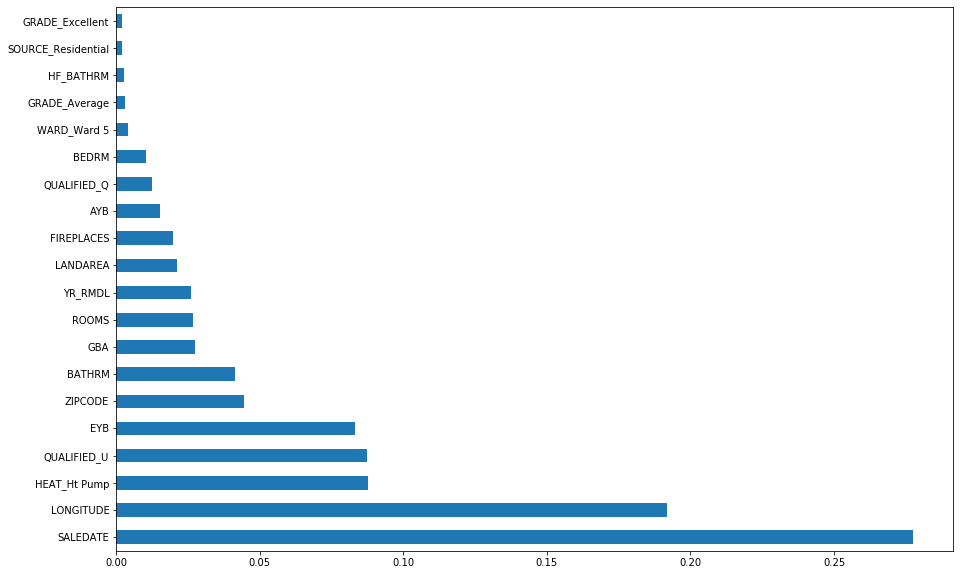

In [107]:
figure = plt.figure(figsize = (15, 10))
(pd.Series(RF.feature_importances_, index=x_train.columns).nlargest(20).plot(kind='barh'))
fig.suptitle('Les variables explicatives et leurs importances', fontsize=16)

On remaque que le facteur le plus important pour le modèle sélectionné est la date de vente et la position (zipcode, longitude...).
Comme on peut s'y attendre, des autres facteurs sont assez importants pour définir le prix de vente comme la superficie, le nombre de pièce et l'année de construction.

###### Source
- https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0 -> Tuning SVR
- http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Data_Manipulation_Pandas.pdf -> Prétraitement et manipulation de la data
- https://datadesignfrench.github.io/Transformations-French.html -> data transformation 
- https://eric.univ-lyon2.fr/~ricco/cours/slides/Reg_Multiple_Colinearite_Selection_Variables.pdf -> variable selection
- https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn -> Code stepwise
- https://jakevdp.github.io/PythonDataScienceHandbook/ -> plots and libraries